In [1]:
import sys
sys.path.append('/home/dan/utils/dspix/geopix/')

First create a list of image files and associated geojson files that contain the bounding boxes.

In [2]:
import glob
import ogr
import re

tifs = glob.glob('AOI_5_Khartoum_Train/RGB-PanSharpen/*.tif')
geojsons = glob.glob('AOI_5_Khartoum_Train/geojson/buildings/*.geojson')

tif_ids = [int(re.findall(r'\d+', tif)[2]) for tif in tifs]
geojson_ids = [int(re.findall(r'\d+', js)[2]) for js in geojsons]

files = [[tifs[i], geojsons[geojson_ids.index(id_)]] for i, id_ in enumerate(tif_ids)]

files[:3]

[['AOI_5_Khartoum_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_5_Khartoum_img801.tif',
  'AOI_5_Khartoum_Train/geojson/buildings/buildings_AOI_5_Khartoum_img801.geojson'],
 ['AOI_5_Khartoum_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_5_Khartoum_img15.tif',
  'AOI_5_Khartoum_Train/geojson/buildings/buildings_AOI_5_Khartoum_img15.geojson'],
 ['AOI_5_Khartoum_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_5_Khartoum_img860.tif',
  'AOI_5_Khartoum_Train/geojson/buildings/buildings_AOI_5_Khartoum_img860.geojson']]

In [3]:
geo = ogr.Open(files[0][1]) # The first geojson
layer = geo.GetLayer()

bboxes = []
for feat in layer:
    geom = feat.GetGeometryRef()
    bbox = geom.GetEnvelope() # minX, maxX, minY, maxY
    bboxes.append(bbox)

bboxes[:2]

[(32.55242543939991,
  32.55248588344214,
  15.622622048907397,
  15.622655417764685),
 (32.55209724709735,
  32.55239874953256,
  15.622621199955649,
  15.622719564405314)]

To convert the projected data to pixel coordinates we need the extent of the source image in projected coordinates, we also need to normalize so they are scaled between 0 and 1 (i.e. the *relative position on the image). So repeating with the coordinate transform we get.

In [25]:
import geopix as gp
import gdal

image = gdal.Open(files[0][0]) # The first image

n_x = image.RasterXSize
n_y = image.RasterYSize

gt = image.GetGeoTransform()
gref = gp.Georeference(gt)

layer.ResetReading()

bboxes = []
for feat in layer:
    geom = feat.GetGeometryRef()
    min_x, max_x, min_y, max_y = geom.GetEnvelope()
    
    # Note that transforming to pixel coords shifts the origin to the top left corner
    bbox = gref.world2pix([[min_x, max_y], [max_x, min_y]]).ravel() # minx, miny, maxx, maxy
    bbox = bbox[[1, 0, 3, 2]] / [n_y, n_x, n_y, n_x]
    bboxes.append(bbox)

<IPython.core.display.Javascript object>


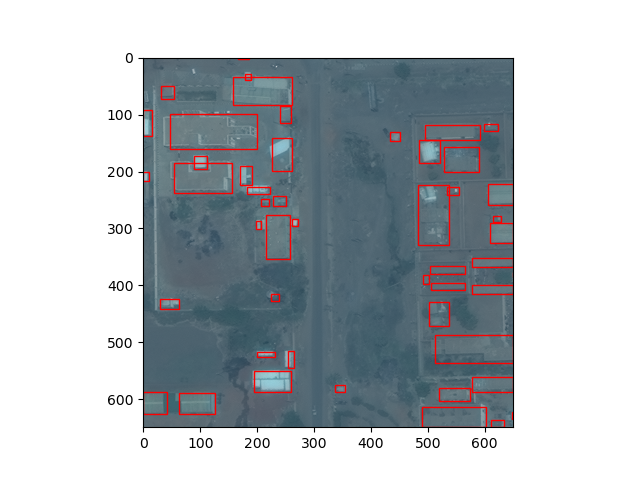

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
%matplotlib notebook

def scale_to_8bit(pix):
    scaled = np.zeros(pix.shape, dtype=float)
    for b in range(len(pix)):
        scaled[b] = pix[b]/pix[b].max()
    
    return (scaled*255)

bands = scale_to_8bit(image.ReadAsArray())
tcc = bands[:3].transpose(1, 2, 0)

def draw_boxes(bboxes, ax):
    '''Draws on the axis image'''
    for box in bboxes:
        xy = box[[1, 0]] * [n_x, n_y]
        w = (box[3]-box[1]) * n_x
        h = (box[2]-box[0]) * n_y
        rect = patches.Rectangle(xy, w, h, lw=1, ec='r', fc='none')
        ax.add_patch(rect)

fig, ax = plt.subplots()
ax.imshow(tcc.astype(int))
draw_boxes(bboxes, ax)

In [42]:
def geojson_to_bboxes(geojson_fn, georef, nx, ny):
    '''
    '''
    json = ogr.Open(geojson_fn)
    layer = json.GetLayer()
    bboxes = []
    for feat in layer:
        geom = feat.GetGeometryRef()
        min_x, max_x, min_y, max_y = geom.GetEnvelope()
        bbox = georef.world2pix([[min_x, max_y], [max_x, min_y]]).ravel() # minx, miny, maxx, maxy
        bbox = bbox[[1, 0, 3, 2]] / [ny, nx, ny, nx]
        bboxes.append(bbox) # ymin, xmin, ymax, xmax
    
    return bboxes

np.stack(geojson_to_bboxes(files[0][1], gref, n_x, n_y))[:5]

array([[9.80502698e-01, 9.41332991e-01, 9.99516292e-01, 9.75774041e-01],
       [9.43951906e-01, 7.54328830e-01, 1.00000003e+00, 9.26125090e-01],
       [9.58270054e-01, 9.97442634e-01, 9.76828738e-01, 1.00000001e+00],
       [9.07713162e-01, 9.57925785e-02, 9.64182095e-01, 1.93326073e-01],
       [9.05149821e-01, 1.34855509e-08, 9.62897301e-01, 6.30422043e-02]])

Now write functions to encode the image data into an `uint8` array with shape (rows, columns, bands) and the bounding boxes for each object. See https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md

In [8]:
import tensorflow as tf

In [18]:
def _int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_list(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_list(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_list(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def encode_sample(name, pixels, boxes):
    '''Creates a tf.Example proto from image data and boxes.
    Args:
        name: The image filename.
        pixels: A numpy array of image data of shape (rows, columns, bands)
        boxes: A numpy array of n boxes with shape (ymin, xmin, ymax, xmax)
    
    Returns:
        example: The tf.Example created.
    '''
    rows, cols, bands = pixels.shape
    
    xmins = boxes[:, 1]
    xmaxs = boxes[:, 3]
    ymins = boxes[:, 0]
    ymaxs = boxes[:, 2]
    classes_text = ['building'.encode('utf8')]*len(boxes)
    classes = [1]*len(boxes)
    
    example = tf.train.Example(
        features=tf.train.Features(
            feature={
                'image/source_id': _bytes(name.encode('utf8')),
                'image/filename': _bytes(name.encode('utf8')),
                'image/height': _int64(rows),
                'image/width': _int64(cols),
                'image/depth': _int64(bands),
                'image/encoded': _bytes(pixels.astype(np.uint8).tobytes()),
                #'image/label': _bytes(labels.astype(np.uint8).tobytes()),
                'image/format': _bytes('tif'.encode('utf8')), # Hardcoded
                'image/object/bbox/xmin': _float_list(xmins),
                'image/object/bbox/xmax': _float_list(xmaxs),
                'image/object/bbox/ymin': _float_list(ymins),
                'image/object/bbox/ymax': _float_list(ymaxs),
                'image/object/class/text': _bytes_list(classes_text),
                'image/object/class/label': _int64_list(classes),
            }))

    return example

Putting it all together to serialize the data to tf.records.

In [19]:
boxes.dtype

dtype('float32')

In [20]:
import os

out_path_template = 'AOI_5_Khartoum_Train/train_records/aoi5_khartoum_{:04d}.tfrecords'

for i, (image_fn, geojson_fn) in enumerate(files):
    # Create a new file every 200 records
    if i % 200 == 0:
        if i != 0:
            writer.close()
        writer = tf.io.TFRecordWriter(out_path_template.format(i))
    
    image = gdal.Open(image_fn)
    n_x = image.RasterXSize
    n_y = image.RasterYSize
    gref = gp.Georeference(image.GetGeoTransform())
    
    # Parse the boxes
    boxes = geojson_to_bboxes(geojson_fn, gref, n_x, n_y)
    if len(boxes) != 0:
        boxes = np.stack(boxes).astype('float32')
    
        # Strip out the filename
        name = os.path.split(os.path.splitext(files[0][1])[0])[1]

        # Load and scale the pixel data
        pixels = scale_to_8bit(image.ReadAsArray())
        pixels = pixels.transpose(1, 2, 0) # Band axis is different to GDAL

        # Serialize and write to file
        record = encode_sample(name, pixels, boxes)
        writer.write(record.SerializeToString())

writer.close()
    

In [206]:
!du -h AOI_5_Khartoum_Train/

1.6G	AOI_5_Khartoum_Train/tfrecords
819M	AOI_5_Khartoum_Train/PAN
15M	AOI_5_Khartoum_Train/summaryData
2.4G	AOI_5_Khartoum_Train/RGB-PanSharpen
412M	AOI_5_Khartoum_Train/MUL
21M	AOI_5_Khartoum_Train/geojson/buildings
21M	AOI_5_Khartoum_Train/geojson
1.1G	AOI_5_Khartoum_Train/train_records
6.4G	AOI_5_Khartoum_Train/MUL-PanSharpen
13G	AOI_5_Khartoum_Train/


In [207]:
!ls -hault AOI_5_Khartoum_Train/train_records

total 1.1G
drwxrwxr-x  2 dan dan 4.0K Dec 12 16:38 .
drwxrwxr-x 10 dan dan 4.0K Dec 12 16:38 ..
-rw-rw-r--  1 dan dan  14M Dec 12 16:38 aoi5_khartoum_1000.tfrecords
-rw-rw-r--  1 dan dan 232M Dec 12 16:38 aoi5_khartoum_0800.tfrecords
-rw-rw-r--  1 dan dan 215M Dec 12 16:38 aoi5_khartoum_0600.tfrecords
-rw-rw-r--  1 dan dan 215M Dec 12 16:38 aoi5_khartoum_0400.tfrecords
-rw-rw-r--  1 dan dan 223M Dec 12 16:38 aoi5_khartoum_0200.tfrecords
-rw-rw-r--  1 dan dan 223M Dec 12 16:38 aoi5_khartoum_0000.tfrecords


In [203]:
!rm -f AOI_5_Khartoum_Train/train_records/*

Check the data from file

In [21]:
raw_dataset = tf.data.TFRecordDataset('AOI_5_Khartoum_Train/train_records/aoi5_khartoum_1000.tfrecords')
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [36]:
# Create a dictionary describing the features.
image_feature_description = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/depth': tf.io.FixedLenFeature([], tf.int64),
    'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
    'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
}

sequence_features = {
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32),
#     'image/object/class/text': tf.io.FixedLenFeature([], tf.int64),
#     'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image/object/bbox/xmax: (None,), image/object/bbox/xmin: (None,), image/object/bbox/ymax: (None,), image/object/bbox/ymin: (None,), image/depth: (), image/encoded: (), image/filename: (), image/height: (), image/width: ()}, types: {image/object/bbox/xmax: tf.float32, image/object/bbox/xmin: tf.float32, image/object/bbox/ymax: tf.float32, image/object/bbox/ymin: tf.float32, image/depth: tf.int64, image/encoded: tf.string, image/filename: tf.string, image/height: tf.int64, image/width: tf.int64}>

<IPython.core.display.Javascript object>


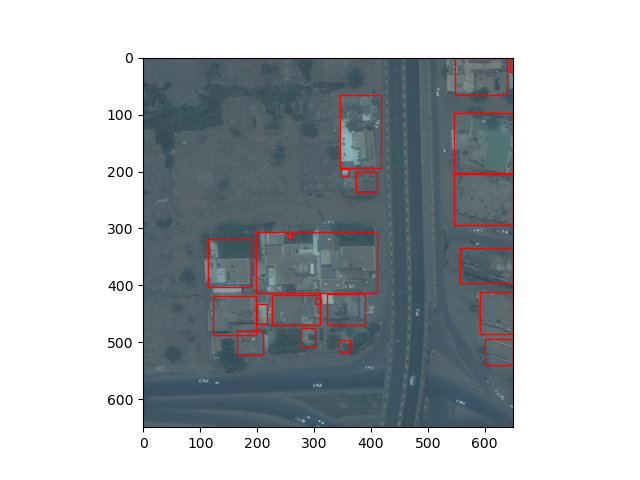

In [40]:
import IPython.display as display

image_feature = list(parsed_image_dataset)[0]
image_raw = image_feature['image/encoded'].numpy()
height = image_feature['image/height'].numpy()
width = image_feature['image/width'].numpy()
image = np.frombuffer(image_raw, np.uint8)

xmins = tf.sparse.to_dense(image_feature['image/object/bbox/xmin'], default_value=0).numpy()
ymins = tf.sparse.to_dense(image_feature['image/object/bbox/ymin'], default_value=0).numpy()
xmaxs = tf.sparse.to_dense(image_feature['image/object/bbox/xmax'], default_value=0).numpy()
ymaxs = tf.sparse.to_dense(image_feature['image/object/bbox/ymax'], default_value=0).numpy()

bs = np.column_stack([ymins, xmins, ymaxs, xmaxs])

fig, ax = plt.subplots()
ax.imshow(image.reshape(height, width, 3))
draw_boxes(bs, ax)    